In [9]:
import matplotlib.pyplot as plt
import numpy as np 

from matplotlib.animation import FuncAnimation
import os
from IPython.display import HTML



# 2D

In [ ]:
params = np.loadtxt('/home/janne/bacteria/anti_mips_spinoff/params.dat',usecols=1,dtype=None)
N = int(params[0])
Lx = int(params[1])
Ly = int(params[2])
eta = params[4]
T  = int(params[5])
Vo = params[-1]
R = params[3]
Dt = params[6]

filename = f'XY_N_{N}_Lx_{Lx}_Ly_{Ly}_R_{R:g}_eta_{eta}_T_{T}_Dt_{Dt}_Vo_{Vo:g}'
Data = np.loadtxt('/home/janne/bacteria/anti_mips_spinoff/' + filename + '.dat')

X,Y,Theta = Data[:,0],Data[:,1],Data[:,2]

T = len(X)//N

X = np.reshape(X, (T,N))
Y = np.reshape(Y, (T,N))

Theta = np.reshape(Theta, (T,N))
fig, ax1 = plt.subplots(figsize=(8,3.5))  
scale = 0.5
x,y = [], []


In [ ]:

def animate(i):
    frame_index = i
    ax1.clear()
    
    Array1 = X[i]
    Array3 = Y[i]
    Array2 = Theta[i]
    
    output_folder = f'/home/janne/bacteria/anti_mips_spinoff/movies/frames_{filename}'
    os.makedirs(output_folder, exist_ok=True)
    
    for posx, posy, angle in zip(Array1,Array3, Array2):
       
        x = posx
        y = posy 
        dx = np.cos(angle)*scale
        dy = np.sin(angle)*scale
        
        ax1.add_patch(plt.Circle((x, y), radius=0.5, fill=True, color='red'))
        ax1.arrow(x, y, dx, dy, head_width=1.05, head_length=1.05,color='black')
        ax1.set_title(f'frame {i}')
        
    ax1.set_xlim(0, Lx)
    ax1.set_ylim(0,Ly)
    
    ax1.set_aspect('equal', adjustable='box')
    
    frame_filename = f'/home/janne/bacteria/anti_mips_spinoff/movies/frames_{filename}/frame_{frame_index:03d}.png'
    # plt.savefig(frame_filename,dpi=300)
    
ani = FuncAnimation(fig,animate, frames=np.arange(T), interval=120, repeat=False,blit=False)
plt.show() 
        
HTML(ani.to_jshtml())

# 1D case

In [80]:
params = np.loadtxt('/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/params.dat',usecols=1,dtype=None)
N = int(params[0])
Lx = int(params[1])
# Ly = int(params[2])
eta = params[3]
T  = int(params[4])
Vo = params[6]
R = params[2]
Dt = params[5]
gamma = params[7]


filename = f'XY_N_{N}_Lx_{Lx}_R_{R:g}_eta_{eta}_T_{T}_Dt_{Dt}_Vo_{Vo:g}_gamma_{gamma:g}'
Data = np.loadtxt('/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/' + filename + '.dat')

X,Theta = Data[:,0],Data[:,1]

T = len(X)//N

X = np.reshape(X, (T,N))
# Y = np.reshape(Y, (T,N))

Theta = np.reshape(Theta, (T,N))



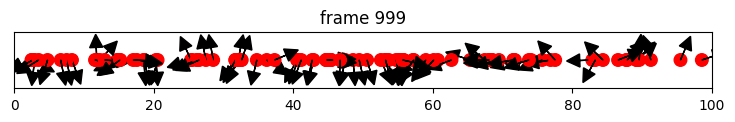

In [78]:

fig, ax1 = plt.subplots(figsize=(9,4))  
scale = 1.8
x,y = [], []
for i in range(T):
    frame_index = i
    ax1.clear()
    
    Array1 = X[i]
    # Array3 = Y[i]
    Array2 = Theta[i]
    
    output_folder = f'/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/movies/frames_{filename}'
    os.makedirs(output_folder, exist_ok=True)
    
    for posx, angle in zip(Array1,Array2):
       
        x = posx
        y = 0
        dx = np.cos(angle)*scale
        dy = np.sin(angle)*scale
        
        ax1.add_patch(plt.Circle((x, y), radius=0.5*scale, fill=True, color='red'))
        ax1.arrow(x, y, dx, dy, head_width=1.05*scale, head_length=1.05*scale,color='black')
        ax1.set_title(f'frame {i}')
        
    ax1.set_xlim(0, Lx)
    ax1.set_yticks([])
    
    ax1.set_aspect('equal', adjustable='box')
    
    frame_filename = f'/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/movies/frames_{filename}/frame_{frame_index:03d}.png'
    plt.savefig(frame_filename,dpi=300)
    # fig.clf()
    
# ani = FuncAnimation(fig,animate, frames=np.arange(T), interval=120, repeat=False,blit=False)
# plt.show() 
        
# HTML(ani.to_jshtml())

# Density profile 

In [2]:
from numba import njit

In [81]:
@njit
def rho_prof(sigma,X2,L,T_steps,Ltotal):
    rho = np.zeros((T_steps,L))
    for i in range(T_steps):
        for j in range(L):
            aux = (Ltotal[j] - X2[i,:])**2
            rho[i][j] = np.sum( np.exp(  -aux/(2*sigma**2)    ))
    return rho



In [82]:
@njit
def mag_prof(sigma,X2,theta2,L,T_steps,Ltotal):
    mag = np.zeros((T_steps,L))
    for i in range(T_steps):
        spin=np.zeros((N,1))
        for j in range(N):
            if np.cos(theta2[i][j])<0:
                spin[j]=-1
            else:
                spin[j]=1
            
        for j in range(L):
            aux = spin.T*np.exp(-(Ltotal[j] - X2[i,:])**2/(2*sigma**2)) 
            mag[i][j] = np.sum(aux)
    return mag

In [89]:
sigma=4
rho = rho_prof(sigma,X,Lx,T,np.arange(Lx))
mag = mag_prof(sigma,X,Theta,Lx,T,np.arange(Lx))

In [87]:
def plot_density_profile(rho,mag,L,N,time,sigma,filename,save=None):
    x = np.arange(L)
    
    # for i in range(579,590):
    fig, ax = plt.subplots(figsize=(5,4))
    f = rho[time]
    g = mag[time]
    norm = N/np.trapz(f,dx=sigma)
    f = f*norm
    g = g/N
    
    # ax.set_xlim(0,500)
    # ax.set_ylim(-50,50)



    # ax.set_title(r'N = %i, $\eta = $ %0.1f, time = %i, $\bar{\rho} = $ %.1f' %(N,eta,Time[i],rho0))
    ax.plot(x,f,label = r'$\tilde{\rho}(x,t)$', c='blue' )
    ax.plot(x,g,label = r'$\tilde{m}(x,t)$', c='red' )


    # ax.tick_params(labelsize=20)
    # ax.set_xticks((0,L/2,L))
    # ax.set_yticks((0,400,690))
    # ax.set_yticklabels(['0','0.5','1'])
    ax.set_xlabel(r'$x$')
    ax.legend(fontsize=13)
    if save == True:
        plt.savefig(filename,dpi=300)
    else:
        pass
    return plt.close()

# plot_density_profile(rho,mag,Lx,N,13,sigma,'nothing',save=False)

In [92]:
os.makedirs('/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/density_profs/' + filename,exist_ok = True)
for time in range(600,T):
    
    name = f'/home/janne/bacteria/anti_mips_spinoff/abs_antimips_1d/density_profs/' + filename + f'/frame_{time:04d}.png'
    plot_density_profile(rho,mag,Lx,N,time,sigma,name,save=True)

In [ ]:
import pandas as pd

dataframe = pd.DataFrame('/')